In [2]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
import numpy as np

## 1. Классификация предметов одежды (датасет Fashion MNIST)



### 1.1 Решить задачу классификации, не используя сверточные слои. 
* Предложить архитектуру модели для решения задачи
* Посчитать количество параметров модели.
* Обучить модель
* Вывести график функции потерь по эпохам. 
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
* Сохранить модель

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
data_train = datasets.FashionMNIST('./data', download = True, train = True, transform = transform)
data_test = datasets.FashionMNIST('./data', download = True, train = False, transform = transform)

In [3]:
traindata = DataLoader(data_train, batch_size = 100, shuffle = True)
testdata = DataLoader(data_test, batch_size = 100, shuffle = True)

In [4]:
dataiter = iter(traindata)
data = dataiter.next()
features, labels = data

In [5]:
print('Количество параметров модели', features[0].shape)

Количество параметров модели torch.Size([1, 28, 28])


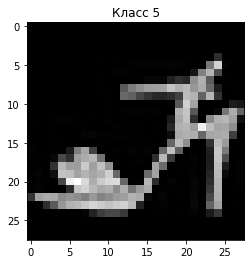

In [6]:
#пример картинки
plt.imshow(torch.squeeze(features[0]), cmap = 'gray')
plt.title('Класс '+ str(labels[0].item()))
plt.show()

In [7]:
print('Количество классов', len(torch.unique(labels)))

Количество классов 10


In [9]:
# 1. Определить модель
n_features = 784
n_neurons_1 = 200
n_neurons_2 = 100
n_neurons_3 = 20
n_outputs = 10
losses = []

class Model(nn.Module):
  def __init__(self, n_features, n_neurons_1, n_neurons_2, n_neurons_3, n_outputs):
    super().__init__()
    self.fc1 = nn.Linear(n_features, n_neurons_1)
    self.fc2 = nn.Linear(n_neurons_1, n_neurons_2)
    self.fc3 = nn.Linear(n_neurons_2, n_neurons_3)
    self.fc4 = nn.Linear(n_neurons_3, n_outputs)
    
  def forward(self, X):
    X = X.view(X.shape[0],-1)
    out1 = self.fc1(X)
    out2 = nn.ReLU()(out1)
    out3 = nn.ReLU()(self.fc2(out2))
    out4 = nn.Sigmoid()(self.fc3(out3))
    y_pred = self.fc4(out4)
    return y_pred

model = Model(n_features, n_neurons_1, n_neurons_2, n_neurons_3, n_outputs)

#2. Определиться с функцией потерь
criterion = nn.CrossEntropyLoss()

# 3. Определяемся с методом оптимизации
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# 4. Процесс обучения
for i in range(80):
  model.train()
  losses_epoch = []
  for x_example, y_example in traindata:
      y_pred = model(x_example)
    
      loss = criterion(y_pred, y_example)
      losses_epoch.append(loss.item())
      loss.backward()
        
      optimizer.step()
      optimizer.zero_grad()
 
  losses.append(np.mean(losses_epoch))
  if i%5==0:
    print(f'epoch {i}: loss = {np.mean(losses_epoch):.8f}') 

epoch 0: loss = 1.54999883
epoch 5: loss = 0.48126268
epoch 10: loss = 0.36132002
epoch 15: loss = 0.30458340
epoch 20: loss = 0.27109179
epoch 25: loss = 0.24104132
epoch 30: loss = 0.22009136
epoch 35: loss = 0.20021904
epoch 40: loss = 0.18340803
epoch 45: loss = 0.16818357
epoch 50: loss = 0.15544113
epoch 55: loss = 0.14659796
epoch 60: loss = 0.13551915
epoch 65: loss = 0.12446643
epoch 70: loss = 0.11514999
epoch 75: loss = 0.10585804


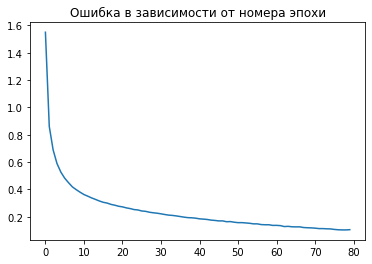

In [10]:
plt.plot(list(range(len(losses))), losses)
plt.title('Ошибка в зависимости от номера эпохи')
plt.show()

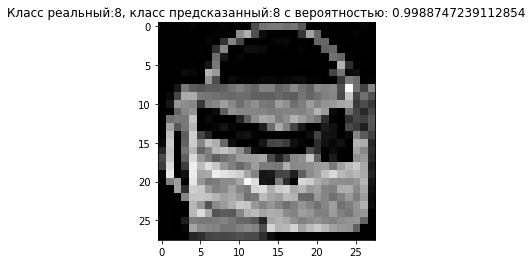

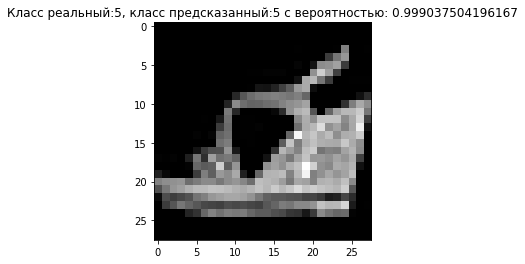

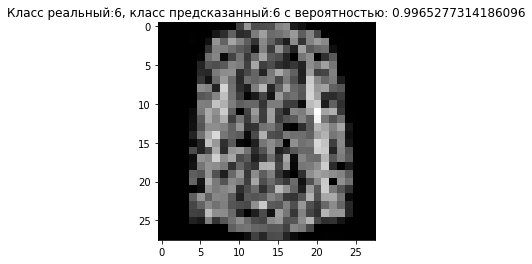

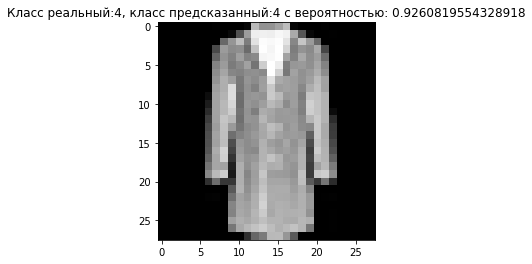

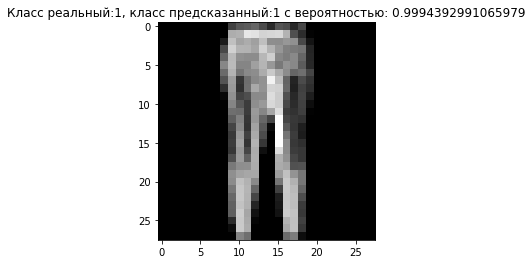

In [11]:
dataiter = iter(testdata)
data = dataiter.next()
features, labels = data
for i in range(5):
    x_example = features[i]
    y_example = labels[i]
    y_pred = model(x_example)
    plt.imshow(torch.squeeze(x_example), cmap = 'gray')
    plt.title('Класс реальный:'+ str(y_example.item())+', класс предсказанный:'+str(torch.argmax(y_pred).item())+
              ' с вероятностью: '+str(torch.max(nn.Softmax(dim = 1)(y_pred)).item()))
    plt.show()

In [12]:
y_pred = []
y_true = []
for x,y in testdata:
    y_pred.extend(model(x))
    y_true.extend(y)
y_pred = list(map(lambda x: torch.argmax(x).item(), y_pred))
y_true = list(map(lambda x: x.item(), y_true))

In [13]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_true, y_pred)

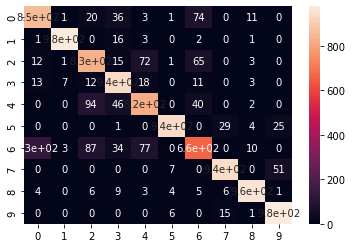

In [14]:
import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True)
plt.show()

In [15]:
from sklearn.metrics import accuracy_score
print('Точность на тестовой выборке:', accuracy_score(y_true, y_pred))

Точность на тестовой выборке: 0.8897


### 1.2 Решить задачу 1.1, используя сверточную нейронную сеть. 
* Добиться значения accuracy на тестовом множестве не менее 90%
* Визуализировать результаты работы первого сверточного слоя

In [78]:
ex1 = features[0]
print('ex1:', ex1.shape)

conv1 = nn.Conv2d(1, 32, kernel_size=3)
ex2 = conv1(ex1)
print('ex2:', ex2.shape)

conv2 = nn.Conv2d(32, 64, kernel_size=3)
ex3 = conv2(ex2)
print('ex3:', ex3.shape)
ex4 = F.max_pool2d(ex3, 2)
print('ex4:', ex4.shape)

ex1: torch.Size([1, 28, 28])
ex2: torch.Size([32, 26, 26])
ex3: torch.Size([64, 24, 24])
ex4: torch.Size([64, 12, 12])


In [79]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv2_drop = nn.Dropout2d() 
        self.fc1 = nn.Linear(64*12*12, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x)) # первый сверточный слой
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2)) # второй сверточный слой
        x = x.view(-1, 64*12*12) # в двухмерный тензор 
        x = nn.Softplus()(self.fc1(x)) # первый полносвязный слой
        x = F.dropout(x, training=self.training)
        x = self.fc2(x) # второй полносвязный слой
        return x
    
    def forward_1l(self, x):    
        x = F.max_pool2d(F.relu(self.conv1(x))) # первый сверточный слой
        return x

In [83]:
model = Net()

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses = []
test_losses = []

for i in range(30):
    model.train()
    losses_epoch_train = []
    losses_epoch_test = []
    y_pred_test = []
    y_true_test = []
    for x_example, y_example in traindata:
        y_pred = model(x_example)
    
        loss = criterion(y_pred, y_example)
        losses_epoch_train.append(loss.item())
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()
        
    for x_example, y_example in testdata:
        y_pred = model(x_example)
    
        loss = criterion(y_pred, y_example)
        losses_epoch_test.append(loss.item())
        
        y_pred_test.extend(y_pred)
        y_true_test.extend(y_example)
    
    y_pred_test = list(map(lambda x: torch.argmax(x).item(), y_pred_test))
    y_true_test = list(map(lambda x: x.item(), y_true_test))
    train_losses.append(np.mean(losses_epoch_train))
    test_losses.append(np.mean(losses_epoch_test))
    if i%5==0:
        print(f'epoch {i}: train_loss = {np.mean(losses_epoch_train):.8f}, test_loss = {np.mean(losses_epoch_test):.8f}') 
        print('Точность на тестовой выборке:', accuracy_score(y_true_test, y_pred_test))

epoch 0: train_loss = 0.55240832, test_loss = 0.42634061
Точность на тестовой выборке: 0.844
epoch 5: train_loss = 0.24982606, test_loss = 0.30131445
Точность на тестовой выборке: 0.8944
epoch 10: train_loss = 0.19543812, test_loss = 0.28179761
Точность на тестовой выборке: 0.9024
epoch 15: train_loss = 0.16075855, test_loss = 0.29857974
Точность на тестовой выборке: 0.9053
epoch 20: train_loss = 0.14045045, test_loss = 0.31279332
Точность на тестовой выборке: 0.9079
epoch 25: train_loss = 0.12398476, test_loss = 0.33027700
Точность на тестовой выборке: 0.9106


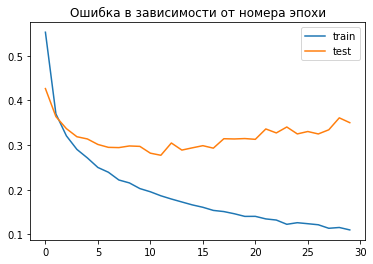

In [84]:
plt.plot(list(range(len(train_losses))), train_losses, label = 'train')
plt.plot(list(range(len(test_losses))), test_losses, label = 'test')
plt.title('Ошибка в зависимости от номера эпохи')
plt.legend()
plt.show()

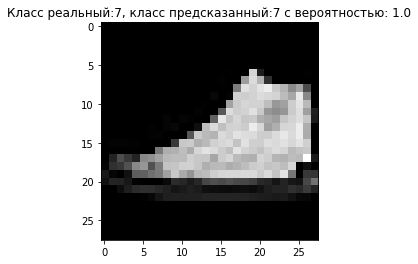

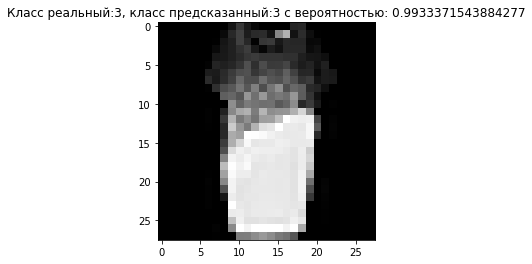

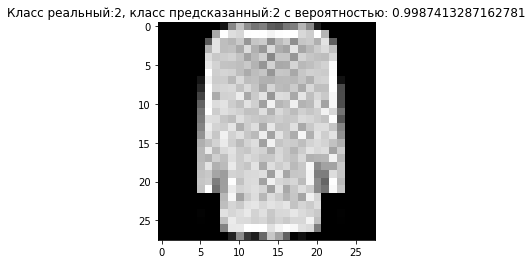

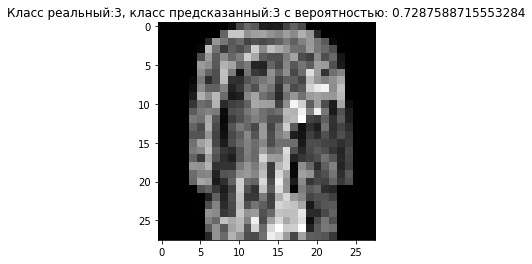

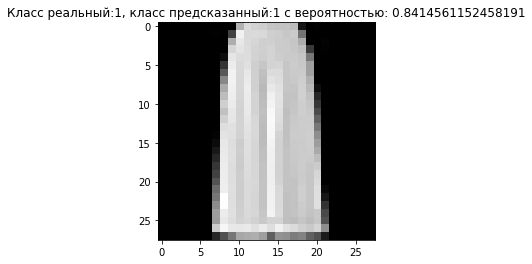

In [87]:
dataiter = iter(testdata)
data = dataiter.next()
features, labels = data
for i in range(5):
    x_example = features[i]
    y_example = labels[i]
    y_pred = model(x_example)
    plt.imshow(torch.squeeze(x_example), cmap = 'gray')
    plt.title('Класс реальный:'+ str(y_example.item())+', класс предсказанный:'+str(torch.argmax(y_pred).item())+
              ' с вероятностью: '+str(torch.max(nn.Softmax(dim = 1)(y_pred)).item()))
    plt.show()

In [89]:
y_pred = []
y_true = []
for x,y in testdata:
    y_pred.extend(model(x))
    y_true.extend(y)
y_pred = list(map(lambda x: torch.argmax(x).item(), y_pred))
y_true = list(map(lambda x: x.item(), y_true))

In [90]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_true, y_pred)

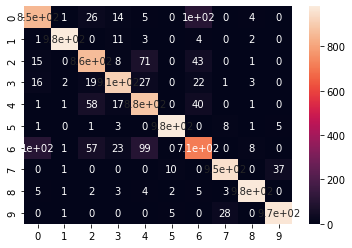

In [91]:
import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True)
plt.show()

In [92]:
from sklearn.metrics import accuracy_score
print('Точность на тестовой выборке:', accuracy_score(y_true, y_pred))

Точность на тестовой выборке: 0.9066


torch.Size([32, 13, 13])


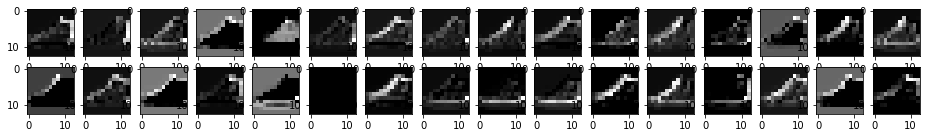

In [104]:
img_n = 7
with torch.no_grad():
    data1_part_1l = model.forward_1l(features[0])

    print(data1_part_1l.shape)
    nplots = data1_part_1l.shape[0]
    ncols = 16
    
    nrows = 1 + nplots//ncols
    count = 0
    fig = plt.figure(figsize=(ncols, nrows))    
    
    for i in range(data1_part_1l.shape[0]):
        count += 1
        ax1 = fig.add_subplot(nrows, ncols, count)
            
        ax1.imshow(data1_part_1l[i], cmap='gray')

##  2. Классификация изображений (датасет CIFAR 10) 


### 2.1 Решить задачу классификации, не используя сверточные слои. 

* Нормализовать данные (если необходимо)
* Предложить архитектуру модели для решения задачи
* Посчитать количество параметров модели.
* Обучить модель
* Вывести график функции потерь по эпохам. 
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
* Сохранить модель

In [21]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
data_train = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
data_test = datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [22]:
traindata = DataLoader(data_train, batch_size = 100, shuffle = True)
testdata = DataLoader(data_test, batch_size = 100, shuffle = True)

In [23]:
dataiter = iter(traindata)
data = dataiter.next()
features, labels = data

In [109]:
print('Количество параметров модели', features[0].shape)

Количество параметров модели torch.Size([3, 32, 32])


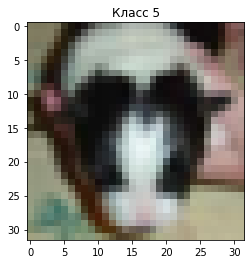

In [110]:
#пример картинки
img = torchvision.utils.make_grid(features[0])
img = img / 2 + 0.5     
npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.title('Класс '+ str(labels[0].item()))
plt.show()

In [111]:
print('Количество классов', len(torch.unique(labels)))

Количество классов 10


In [23]:
# 1. Определить модель
n_features = 3*32*32
n_neurons_1 = 800
n_neurons_2 = 200
n_neurons_3 = 40
n_outputs = 10
losses = []

class Model(nn.Module):
  def __init__(self, n_features, n_neurons_1, n_neurons_2, n_neurons_3, n_outputs):
    super().__init__()
    self.fc1 = nn.Linear(n_features, n_neurons_1)
    self.fc2 = nn.Linear(n_neurons_1, n_neurons_2)
    self.fc3 = nn.Linear(n_neurons_2, n_neurons_3)
    self.fc4 = nn.Linear(n_neurons_3, n_outputs)
    
  def forward(self, X):
    X = X.view(X.shape[0],-1)
    out1 = self.fc1(X)
    out2 = nn.ReLU()(out1)
    out3 = nn.Sigmoid()(self.fc2(out2))
    out4 = nn.ReLU()(self.fc3(out3))
    y_pred = self.fc4(out4)
    return y_pred

model = Model(n_features, n_neurons_1, n_neurons_2, n_neurons_3, n_outputs)

#2. Определиться с функцией потерь
criterion = nn.CrossEntropyLoss()

# 3. Определяемся с методом оптимизации
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# 4. Процесс обучения
for i in range(10):
  model.train()
  losses_epoch = []
  for x_example, y_example in traindata:
      y_pred = model(x_example)
    
      loss = criterion(y_pred, y_example)
      losses_epoch.append(loss.item())
      loss.backward()
        
      optimizer.step()
      optimizer.zero_grad()
 
  losses.append(np.mean(losses_epoch))
  print(f'epoch {i}: loss = {np.mean(losses_epoch):.8f}') 

epoch 0: loss = 2.12613760
epoch 1: loss = 1.78616901
epoch 2: loss = 1.60854040
epoch 3: loss = 1.49233966
epoch 4: loss = 1.40235828
epoch 5: loss = 1.33275396
epoch 6: loss = 1.27531679
epoch 7: loss = 1.21620739
epoch 8: loss = 1.17275870
epoch 9: loss = 1.12192476


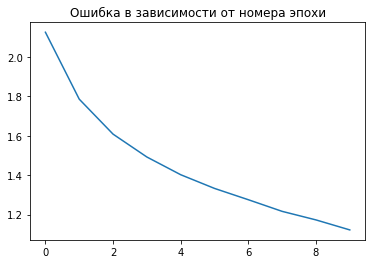

In [24]:
plt.plot(list(range(len(losses))), losses)
plt.title('Ошибка в зависимости от номера эпохи')
plt.show()

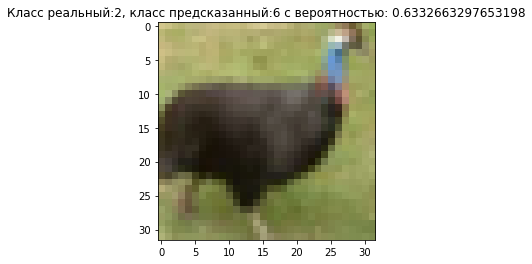

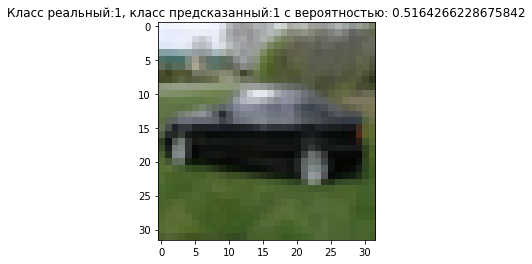

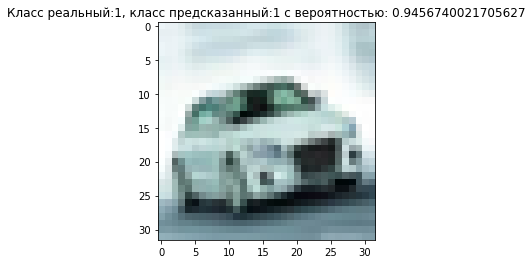

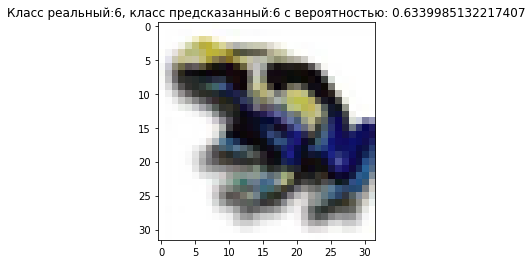

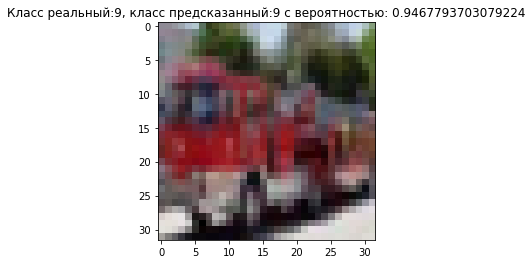

In [25]:
dataiter = iter(testdata)
data = dataiter.next()
features, labels = data
for i in range(5):
    x_example = features[i]
    y_example = labels[i]
    a = x_example.view(-1,1)
    a = a.reshape(1,len(a))
    y_pred = model(a)
    img = torchvision.utils.make_grid(x_example)
    img = img / 2 + 0.5     
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title('Класс реальный:'+ str(y_example.item())+', класс предсказанный:'+str(torch.argmax(y_pred).item())+
              ' с вероятностью: '+str(torch.max(nn.Softmax(dim = 1)(y_pred)).item()))
    plt.show()

In [26]:
y_pred = []
y_true = []
for x,y in testdata:
    y_pred.extend(model(x))
    y_true.extend(y)
y_pred = list(map(lambda x: torch.argmax(x).item(), y_pred))
y_true = list(map(lambda x: x.item(), y_true))

In [27]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_true, y_pred)

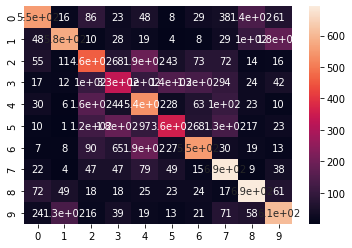

In [28]:
import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True)
plt.show()

In [29]:
from sklearn.metrics import accuracy_score
print('Точность на тестовой выборке:', accuracy_score(y_true, y_pred))

Точность на тестовой выборке: 0.5355


### 2.2 Решить задачу 2.1, используя сверточную нейронную сеть. 
* Добиться значения accuracy на тестовом множестве не менее 70%.
* Визуализировать результаты работы первого сверточного слоя

In [24]:
ex1 = features[0]
print('ex1:', ex1.shape)

conv1 = nn.Conv2d(3, 32, kernel_size=3)
ex2 = conv1(ex1)
print('ex2:', ex2.shape)
conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
ex3 = conv2(ex2)
print('ex3:', ex3.shape)

ex4 =  F.max_pool2d(ex3, 2)
print('ex4:', ex4.shape)

conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
ex5 = conv3(ex4)
print('ex5:', ex5.shape)
conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
ex6 = conv4(ex5)
print('ex6:', ex6.shape)

ex7 =  F.max_pool2d(ex6, 2)
print('ex7:', ex7.shape)

conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
ex8 = conv5(ex7)
print('ex8:', ex8.shape)
conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
ex9 = conv6(ex8)
print('ex9:', ex9.shape)

ex10 =  F.max_pool2d(ex9, 2)
print('ex10:', ex10.shape)

ex1: torch.Size([3, 32, 32])
ex2: torch.Size([32, 30, 30])
ex3: torch.Size([64, 30, 30])
ex4: torch.Size([64, 15, 15])
ex5: torch.Size([128, 15, 15])
ex6: torch.Size([128, 15, 15])
ex7: torch.Size([128, 7, 7])
ex8: torch.Size([256, 7, 7])
ex9: torch.Size([256, 7, 7])
ex10: torch.Size([256, 3, 3])


In [25]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size = 3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size = 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size = 3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size = 3, padding=1)
        self.conv5 = nn.Conv2d(128, 256, kernel_size = 3, padding=1)
        self.conv6 = nn.Conv2d(256, 256, kernel_size = 3, padding=1)
        self.fc1 = nn.Linear(256*3*3, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x)) # первый сверточный слой
        x = F.max_pool2d(F.relu(self.conv2(x)),2) # второй сверточный слой
        x = F.relu(self.conv3(x)) # третий сверточный слой
        x = F.max_pool2d(F.relu(self.conv4(x)),2) # четвертый сверточный слой
        x = F.relu(self.conv5(x)) # пятый сверточный слой
        x = F.max_pool2d(F.relu(self.conv6(x)),2) # шестой сверточный слой
        x = F.dropout(x, training=self.training)
        x = x.view(-1, 256*3*3) # в двухмерный тензор 
        x = F.relu(self.fc1(x)) # первый полносвязный слой
        x = F.relu(self.fc2(x)) # второй полносвязный слой
        x = self.fc3(x)# третий полносвязный слой
        return x
    
    def forward_1l(self, x):    
        x = F.relu(self.conv1(x)) # первый сверточный слой
        return x

In [26]:
model = Net()

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses = []
test_losses = []

for i in range(4):
    model.train()
    losses_epoch_train = []
    losses_epoch_test = []
    y_pred_test = []
    y_true_test = []
    for x_example, y_example in traindata:
        y_pred = model(x_example)
    
        loss = criterion(y_pred, y_example)
        losses_epoch_train.append(loss.item())
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()
        
    for x_example, y_example in testdata:
        y_pred = model(x_example)
    
        loss = criterion(y_pred, y_example)
        losses_epoch_test.append(loss.item())
        
        y_pred_test.extend(y_pred)
        y_true_test.extend(y_example)
        
    train_losses.append(np.mean(losses_epoch_train))
    test_losses.append(np.mean(losses_epoch_test))
    y_pred_test = list(map(lambda x: torch.argmax(x).item(), y_pred_test))
    y_true_test = list(map(lambda x: x.item(), y_true_test))
    print(f'epoch {i}: train_loss = {np.mean(losses_epoch_train):.8f}, test_loss = {np.mean(losses_epoch_test):.8f}') 
    print('Точность на тестовой выборке:', accuracy_score(y_true_test, y_pred_test))

epoch 0: train_loss = 1.67028705, test_loss = 1.31387491
Точность на тестовой выборке: 0.5177
epoch 1: train_loss = 1.14013401, test_loss = 1.09026928
Точность на тестовой выборке: 0.6129
epoch 2: train_loss = 0.90966795, test_loss = 0.88993000
Точность на тестовой выборке: 0.6901
epoch 3: train_loss = 0.75066873, test_loss = 0.76000724
Точность на тестовой выборке: 0.7378


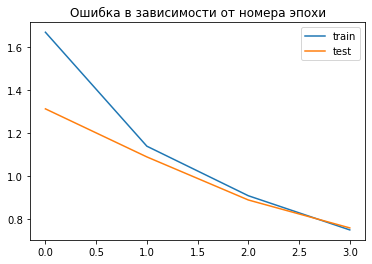

In [27]:
plt.plot(list(range(len(train_losses))), train_losses, label = 'train')
plt.plot(list(range(len(test_losses))), test_losses, label = 'test')
plt.title('Ошибка в зависимости от номера эпохи')
plt.legend()
plt.show()

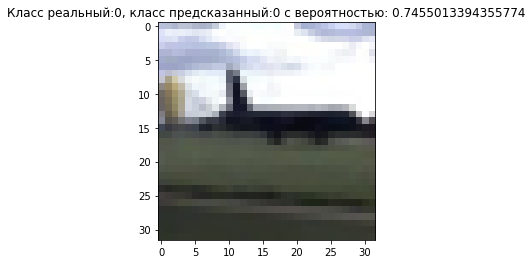

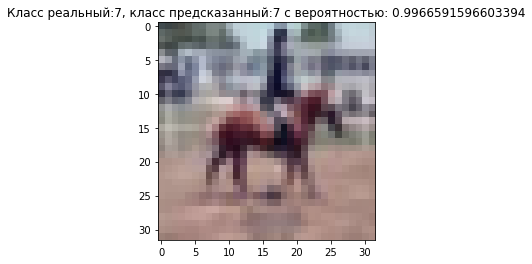

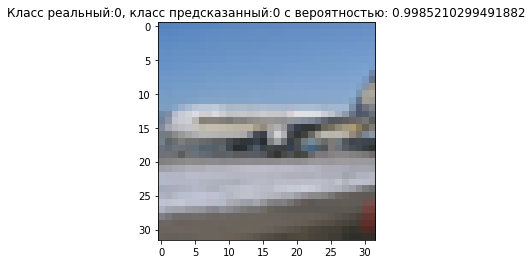

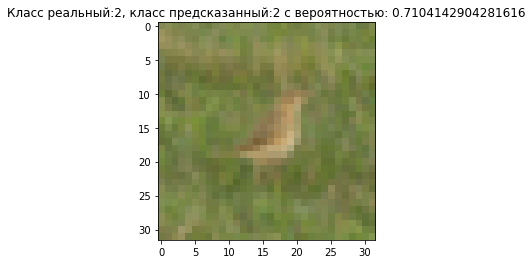

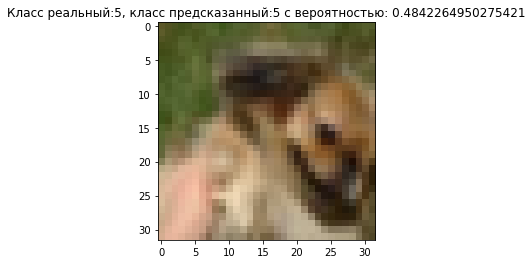

In [28]:
dataiter = iter(testdata)
data = dataiter.next()
features, labels = data
for i in range(5):
    x_example = features[i]
    y_example = labels[i]
    y_pred = model(x_example)
    img = torchvision.utils.make_grid(x_example)
    img = img / 2 + 0.5     
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title('Класс реальный:'+ str(y_example.item())+', класс предсказанный:'+str(torch.argmax(y_pred).item())+
              ' с вероятностью: '+str(torch.max(nn.Softmax(dim = 1)(y_pred)).item()))
    plt.show()

In [29]:
y_pred = []
y_true = []
for x,y in testdata:
    y_pred.extend(model(x))
    y_true.extend(y)
y_pred = list(map(lambda x: torch.argmax(x).item(), y_pred))
y_true = list(map(lambda x: x.item(), y_true))

In [30]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_true, y_pred)

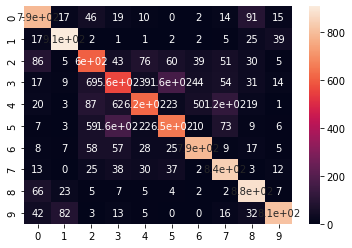

In [31]:
import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True)
plt.show()

In [32]:
from sklearn.metrics import accuracy_score
print('Точность на тестовой выборке:', accuracy_score(y_true, y_pred))

Точность на тестовой выборке: 0.7431


torch.Size([32, 30, 30])


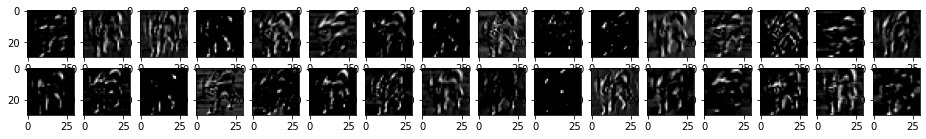

In [127]:
with torch.no_grad():
    data1_part_1l = model.forward_1l(features[0])

    print(data1_part_1l.shape)
    nplots = data1_part_1l.shape[0]
    ncols = 16
    
    nrows = 1 + nplots//ncols
    
    count = 0
    fig = plt.figure(figsize=(ncols, nrows))    
    
    for i in range(data1_part_1l.shape[0]):
        count += 1
        ax1 = fig.add_subplot(nrows, ncols, count)
            
        ax1.imshow(data1_part_1l[i], cmap='gray')

## 3. Загрузка изображений из внешних источников

### 3.1 Решить задачу классификации обезьян (датасет [monkey.zip](https://disk.yandex.ru/d/OxYgY4S7aR6ulQ)).
* Загрузить архив с данными на диск
* Создать датасет на основе файлов при помощи `torchvision.datasets.ImageFolder`
* Преобразовать изображения к тензорами одного размера (например, 400х400). Потестировать другие преобразования из `torchvision.transforms`
* Предложить архитектуру модели для решения задачи. Обучить модель.
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
  * Добиться значения accuracy на тестовом множестве не менее 60%

In [2]:
import zipfile
from tqdm import tqdm

zf = zipfile.ZipFile('monkeys.zip')
for file in tqdm(zf.infolist()):
    zf.extract(file)

100%|█████████████████████████████████████████████████████████████████████████████| 1371/1371 [00:04<00:00, 276.79it/s]


In [37]:
transform = transforms.Compose([transforms.Resize(150),
                                transforms.CenterCrop(150),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
train_dataset = torchvision.datasets.ImageFolder(root='training/training', transform = transform)
test_dataset = torchvision.datasets.ImageFolder(root='validation/validation', transform = transform)

In [38]:
train_loader = DataLoader(train_dataset, batch_size = 100, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 100, shuffle = True)

In [39]:
images, labels = next(iter(train_loader))

In [40]:
print('Количество параметров модели', images[0].shape)

Количество параметров модели torch.Size([3, 150, 150])


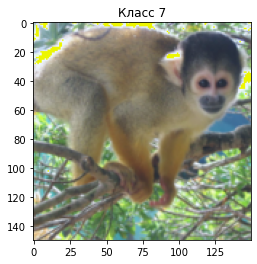

In [43]:
#пример картинки
img = torchvision.utils.make_grid(images[0])
img = img * 0.2 + 0.5     
npimg = img.numpy()
plt.imshow((np.transpose(npimg, (1, 2, 0))* 255).astype(np.uint8))
plt.title('Класс '+ str(labels[0].item()))
plt.show()

In [44]:
print('Количество классов', len(torch.unique(labels)))

Количество классов 10


In [45]:
ex1 = images[0]
print('ex1:', ex1.shape)

conv1 = nn.Conv2d(3, 32, kernel_size=3)
ex2 = conv1(ex1)
print('ex2:', ex2.shape)

ex3 =  F.max_pool2d(ex2, 2)
print('ex3:', ex3.shape)

conv2 = nn.Conv2d(32, 32, kernel_size=3)
ex4 = conv2(ex3)
print('ex4:', ex4.shape)

ex5 =  F.max_pool2d(ex4, 2)
print('ex5:', ex5.shape)

conv2 = nn.Conv2d(32, 64, kernel_size=3)
ex6 = conv2(ex5)
print('ex6:', ex6.shape)

conv2 = nn.Conv2d(64, 64, kernel_size=3)
ex7 = conv2(ex6)
print('ex7:', ex7.shape)

ex8 =  F.max_pool2d(ex7, 2)
print('ex8:', ex8.shape)

ex1: torch.Size([3, 150, 150])
ex2: torch.Size([32, 148, 148])
ex3: torch.Size([32, 74, 74])
ex4: torch.Size([32, 72, 72])
ex5: torch.Size([32, 36, 36])
ex6: torch.Size([64, 34, 34])
ex7: torch.Size([64, 32, 32])
ex8: torch.Size([64, 16, 16])


In [48]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size = 3)
        self.conv2 = nn.Conv2d(32, 32, kernel_size = 3)
        self.conv3 = nn.Conv2d(32, 64, kernel_size = 3)
        self.conv4 = nn.Conv2d(64, 64, kernel_size = 3)
        self.fc1 = nn.Linear(64*16*16, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2) # первый сверточный слой
        x = F.max_pool2d(F.relu(self.conv2(x)), 2) # второй сверточный слой
        x = F.relu(self.conv3(x)) # третий сверточный слой
        x = F.max_pool2d(F.relu(self.conv4(x)), 2) # четвертый сверточный слой
        x = F.dropout(x, 0.25)
        x = x.view(-1, 64*16*16) # в двухмерный тензор 
        x = F.relu(self.fc1(x)) # первый полносвязный слой
        x = F.dropout(x, 0.5)
        x = self.fc2(x) # второй полносвязный слой
        return x

In [50]:
from sklearn.metrics import accuracy_score
model = Net()

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses = []
test_losses = []

for i in range(10):
    model.train()
    losses_epoch_train = []
    losses_epoch_test = []
    y_pred_test = []
    y_true_test = []
    for x_example, y_example in train_loader:
        y_pred = model(x_example)
    
        loss = criterion(y_pred, y_example)
        losses_epoch_train.append(loss.item())
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()
        
    for x_example, y_example in test_loader:
        y_pred = model(x_example)
    
        loss = criterion(y_pred, y_example)
        losses_epoch_test.append(loss.item())
        
        y_pred_test.extend(y_pred)
        y_true_test.extend(y_example)
        
    train_losses.append(np.mean(losses_epoch_train))
    test_losses.append(np.mean(losses_epoch_test))
    y_pred_test = list(map(lambda x: torch.argmax(x).item(), y_pred_test))
    y_true_test = list(map(lambda x: x.item(), y_true_test))
    print(f'epoch {i}: train_loss = {np.mean(losses_epoch_train):.8f}, test_loss = {np.mean(losses_epoch_test):.8f}') 
    print('Точность на тестовой выборке:', accuracy_score(y_true_test, y_pred_test))

epoch 0: train_loss = 2.14371834, test_loss = 1.81491601
Точность на тестовой выборке: 0.36764705882352944
epoch 1: train_loss = 1.59573401, test_loss = 1.59586740
Точность на тестовой выборке: 0.47058823529411764
epoch 2: train_loss = 1.30756184, test_loss = 1.41556474
Точность на тестовой выборке: 0.5036764705882353
epoch 3: train_loss = 1.13585620, test_loss = 1.45441318
Точность на тестовой выборке: 0.5257352941176471
epoch 4: train_loss = 1.02932225, test_loss = 1.38113439
Точность на тестовой выборке: 0.5330882352941176
epoch 5: train_loss = 0.90463008, test_loss = 1.33420543
Точность на тестовой выборке: 0.5698529411764706
epoch 6: train_loss = 0.76762277, test_loss = 1.19802630
Точность на тестовой выборке: 0.5845588235294118
epoch 7: train_loss = 0.59996409, test_loss = 1.29176211
Точность на тестовой выборке: 0.6066176470588235
epoch 8: train_loss = 0.46599498, test_loss = 1.37411928
Точность на тестовой выборке: 0.5808823529411765
epoch 9: train_loss = 0.40027026, test_loss 

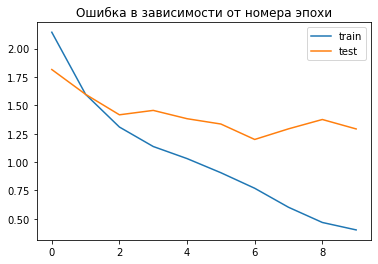

In [51]:
plt.plot(list(range(len(train_losses))), train_losses, label = 'train')
plt.plot(list(range(len(test_losses))), test_losses, label = 'test')
plt.title('Ошибка в зависимости от номера эпохи')
plt.legend()
plt.show()

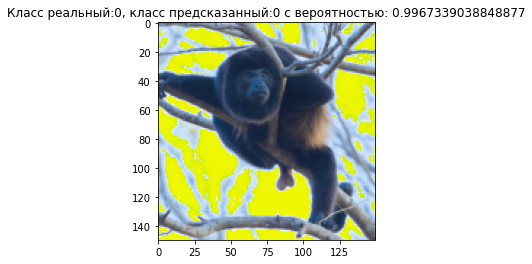

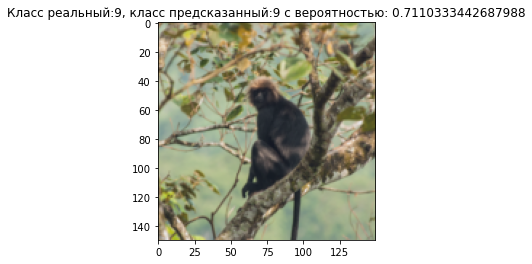

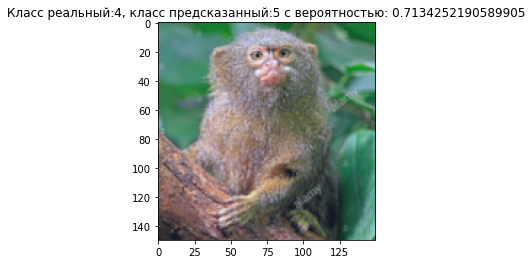

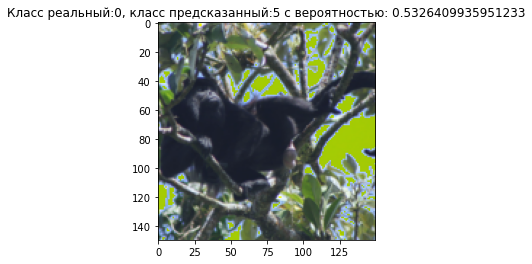

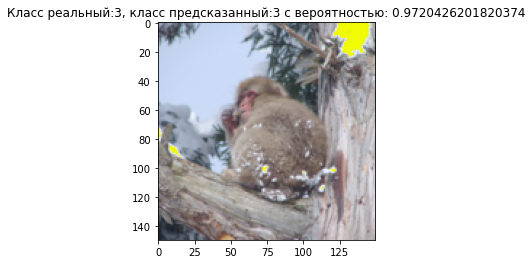

In [54]:
dataiter = iter(test_loader)
data = dataiter.next()
features, labels = data
for i in range(5):
    x_example = features[i]
    y_example = labels[i]
    y_pred = model(x_example)
    img = torchvision.utils.make_grid(x_example)   
    img = img * 0.2 + 0.5    
    npimg = img.numpy()
    plt.imshow((np.transpose(npimg, (1, 2, 0))* 255).astype(np.uint8))
    plt.title('Класс реальный:'+ str(y_example.item())+', класс предсказанный:'+str(torch.argmax(y_pred).item())+
              ' с вероятностью: '+str(torch.max(nn.Softmax(dim = 1)(y_pred)).item()))
    plt.show()

In [55]:
y_pred = []
y_true = []
for x,y in test_loader:
    y_pred.extend(model(x))
    y_true.extend(y)
y_pred = list(map(lambda x: torch.argmax(x).item(), y_pred))
y_true = list(map(lambda x: x.item(), y_true))

In [56]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_true, y_pred)

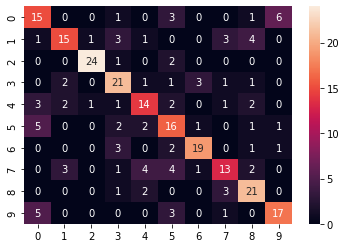

In [57]:
import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True)
plt.show()

In [58]:
from sklearn.metrics import accuracy_score
print('Точность на тестовой выборке:', accuracy_score(y_true, y_pred))

Точность на тестовой выборке: 0.6433823529411765


### 3.2 Решить задачу классификации собак и кошек (датасет [cats_dogs.zip](https://disk.yandex.ru/d/wQtt5O1JF9ctnA)).
* Загрузить архив с данными на диск
* Создать датасет на основе файлов при помощи `torchvision.datasets.ImageFolder`
* Преобразовать изображения к тензорами одного размера (например, 400х400). Потестировать другие преобразования из `torchvision.transforms`
* Предложить архитектуру модели для решения задачи. Обучить модель.
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
  * Добиться значения accuracy на тестовом множестве не менее 80%

In [33]:
import zipfile
from tqdm import tqdm

zf = zipfile.ZipFile('cats_dogs.zip')
for file in tqdm(zf.infolist()):
    zf.extract(file)

100%|███████████████████████████████████████████████████████████████████████████| 25004/25004 [00:38<00:00, 656.95it/s]


In [34]:
transform = transforms.Compose([transforms.Resize(70),
                                transforms.CenterCrop(70),
                                transforms.ToTensor()])
dataset = torchvision.datasets.ImageFolder(root='cats_dogs/train', transform = transform)
data_train, data_test = torch.utils.data.random_split(dataset, [int(25000*0.8), 25000 - int(25000*0.8)])

In [35]:
train_loader = DataLoader(data_train, batch_size = 20, shuffle = True)
test_loader = DataLoader(data_test, batch_size = 20, shuffle = True)

In [36]:
images, labels = next(iter(train_loader))

In [37]:
print('Количество параметров модели', images[0].shape)

Количество параметров модели torch.Size([3, 70, 70])


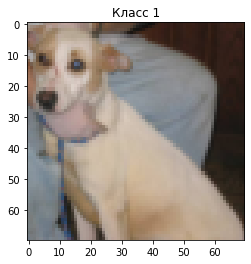

In [38]:
#пример картинки
img = torchvision.utils.make_grid(images[0])  
npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.title('Класс '+ str(labels[0].item()))
plt.show()

In [39]:
print('Количество классов', len(torch.unique(labels)))

Количество классов 2


In [40]:
ex1 = images[0]
print('ex1:', ex1.shape)

conv1 = nn.Conv2d(3, 32, kernel_size=3)
ex2 = conv1(ex1)
print('ex2:', ex2.shape)

ex3 =  F.max_pool2d(ex2, 2)
print('ex3:', ex3.shape)

conv2 = nn.Conv2d(32, 32, kernel_size=3)
ex4 = conv2(ex3)
print('ex4:', ex4.shape)

ex5 =  F.max_pool2d(ex4, 2)
print('ex5:', ex5.shape)

conv2 = nn.Conv2d(32, 64, kernel_size=3)
ex6 = conv2(ex5)
print('ex6:', ex6.shape)

conv2 = nn.Conv2d(64, 64, kernel_size=3)
ex7 = conv2(ex6)
print('ex7:', ex7.shape)

ex8 =  F.max_pool2d(ex7, 2)
print('ex8:', ex8.shape)

ex1: torch.Size([3, 70, 70])
ex2: torch.Size([32, 68, 68])
ex3: torch.Size([32, 34, 34])
ex4: torch.Size([32, 32, 32])
ex5: torch.Size([32, 16, 16])
ex6: torch.Size([64, 14, 14])
ex7: torch.Size([64, 12, 12])
ex8: torch.Size([64, 6, 6])


In [41]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size = 3)
        self.conv2 = nn.Conv2d(32, 32, kernel_size = 3)
        self.conv3 = nn.Conv2d(32, 64, kernel_size = 3)
        self.conv4 = nn.Conv2d(64, 64, kernel_size = 3)
        self.fc1 = nn.Linear(64*6*6, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2) # первый сверточный слой
        x = F.max_pool2d(F.relu(self.conv2(x)), 2) # второй сверточный слой
        x = F.relu(self.conv3(x)) # третий сверточный слой
        x = F.max_pool2d(F.relu(self.conv4(x)), 2) # четвертый сверточный слой
        x = F.dropout(x, 0.25)
        x = x.view(-1, 64*6*6) # в двухмерный тензор 
        x = F.relu(self.fc1(x)) # первый полносвязный слой
        x = F.dropout(x, 0.5)
        x = self.fc2(x) # второй полносвязный слой
        return x

In [42]:
from sklearn.metrics import accuracy_score
model = Net()

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses = []
test_losses = []

for i in range(6):
    model.train()
    losses_epoch_train = []
    losses_epoch_test = []
    y_pred_test = []
    y_true_test = []
    k = 0
    for x_example, y_example in train_loader:
        y_pred = model(x_example)
    
        loss = criterion(y_pred, y_example)
        losses_epoch_train.append(loss.item())
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()
        if k%500==0:
            print(f'epoch {i} bath {k} loss = ',loss.item())
        k+=1
        
    for x_example, y_example in test_loader:
        y_pred = model(x_example)
    
        loss = criterion(y_pred, y_example)
        losses_epoch_test.append(loss.item())
        
        y_pred_test.extend(y_pred)
        y_true_test.extend(y_example)
        
    train_losses.append(np.mean(losses_epoch_train))
    test_losses.append(np.mean(losses_epoch_test))
    y_pred_test = list(map(lambda x: torch.argmax(x).item(), y_pred_test))
    y_true_test = list(map(lambda x: x.item(), y_true_test))
    print(f'epoch {i}: train_loss = {np.mean(losses_epoch_train):.8f}, test_loss = {np.mean(losses_epoch_test):.8f}') 
    print('Точность на тестовой выборке:', accuracy_score(y_true_test, y_pred_test))

epoch 0 bath 0 loss =  2.2805166244506836
epoch 0 bath 500 loss =  0.6918684244155884
epoch 0: train_loss = 0.70625736, test_loss = 0.68724007
Точность на тестовой выборке: 0.5244
epoch 1 bath 0 loss =  0.685125470161438
epoch 1 bath 500 loss =  0.4734657406806946
epoch 1: train_loss = 0.63519395, test_loss = 0.64702613
Точность на тестовой выборке: 0.6196
epoch 2 bath 0 loss =  0.62083500623703
epoch 2 bath 500 loss =  0.6171642541885376
epoch 2: train_loss = 0.57674494, test_loss = 0.52464017
Точность на тестовой выборке: 0.7444
epoch 3 bath 0 loss =  0.4661804139614105
epoch 3 bath 500 loss =  0.4350316524505615
epoch 3: train_loss = 0.51655820, test_loss = 0.50200065
Точность на тестовой выборке: 0.762
epoch 4 bath 0 loss =  0.309527188539505
epoch 4 bath 500 loss =  0.4821361005306244
epoch 4: train_loss = 0.46653733, test_loss = 0.46619579
Точность на тестовой выборке: 0.7828
epoch 5 bath 0 loss =  0.3622164726257324
epoch 5 bath 500 loss =  0.7101556658744812
epoch 5: train_loss

In [50]:
    i = 6
    model.train()
    losses_epoch_train = []
    losses_epoch_test = []
    y_pred_test = []
    y_true_test = []
    k = 0
    for x_example, y_example in train_loader:
        y_pred = model(x_example)
    
        loss = criterion(y_pred, y_example)
        losses_epoch_train.append(loss.item())
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()
        if k%500==0:
            print(f'epoch {i} bath {k} loss = ',loss.item())
        k+=1
        
    for x_example, y_example in test_loader:
        y_pred = model(x_example)
    
        loss = criterion(y_pred, y_example)
        losses_epoch_test.append(loss.item())
        
        y_pred_test.extend(y_pred)
        y_true_test.extend(y_example)
        
    train_losses.append(np.mean(losses_epoch_train))
    test_losses.append(np.mean(losses_epoch_test))
    y_pred_test = list(map(lambda x: torch.argmax(x).item(), y_pred_test))
    y_true_test = list(map(lambda x: x.item(), y_true_test))
    print(f'epoch {i}: train_loss = {np.mean(losses_epoch_train):.8f}, test_loss = {np.mean(losses_epoch_test):.8f}') 
    print('Точность на тестовой выборке:', accuracy_score(y_true_test, y_pred_test))

epoch 6 bath 0 loss =  0.26279136538505554
epoch 6 bath 500 loss =  0.25897708535194397
epoch 6: train_loss = 0.39143276, test_loss = 0.42214802
Точность на тестовой выборке: 0.8068


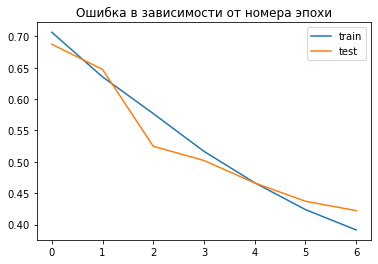

In [51]:
plt.plot(list(range(len(train_losses))), train_losses, label = 'train')
plt.plot(list(range(len(test_losses))), test_losses, label = 'test')
plt.title('Ошибка в зависимости от номера эпохи')
plt.legend()
plt.show()

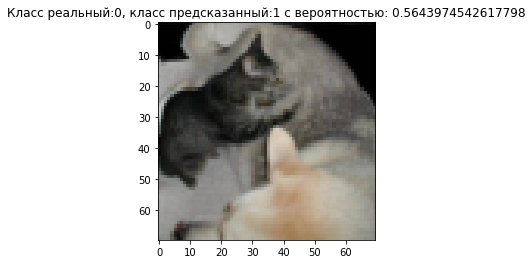

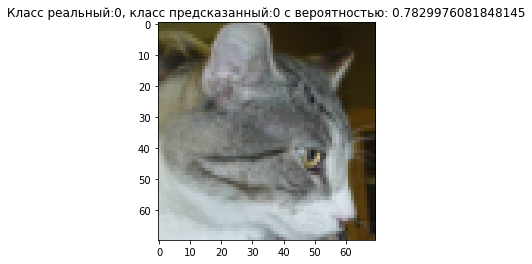

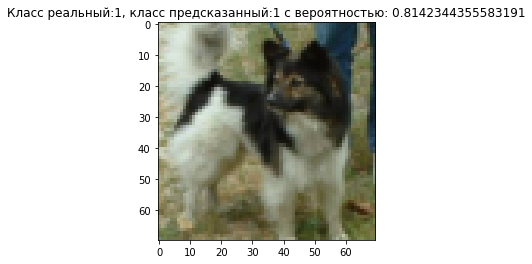

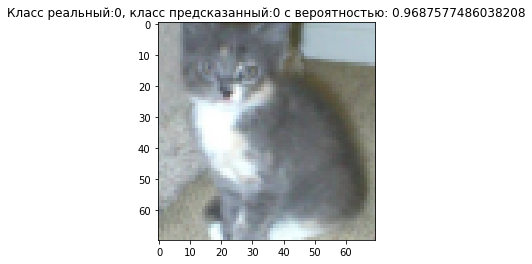

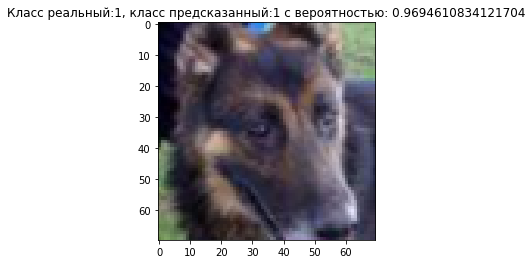

In [52]:
dataiter = iter(test_loader)
data = dataiter.next()
features, labels = data
for i in range(5):
    x_example = features[i]
    y_example = labels[i]
    y_pred = model(x_example)
    img = torchvision.utils.make_grid(x_example)    
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title('Класс реальный:'+ str(y_example.item())+', класс предсказанный:'+str(torch.argmax(y_pred).item())+
              ' с вероятностью: '+str(torch.max(nn.Softmax(dim = 1)(y_pred)).item()))
    plt.show()

In [53]:
y_pred = []
y_true = []
for x,y in test_loader:
    y_pred.extend(model(x))
    y_true.extend(y)
y_pred = list(map(lambda x: torch.argmax(x).item(), y_pred))
y_true = list(map(lambda x: x.item(), y_true))

In [54]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_true, y_pred)

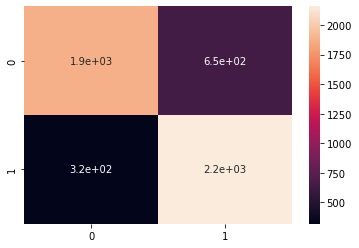

In [55]:
import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True)
plt.show()

In [56]:
from sklearn.metrics import accuracy_score
print('Точность на тестовой выборке:', accuracy_score(y_true, y_pred))

Точность на тестовой выборке: 0.8064


# 4. Transfer Learning

### 4.1 Решить задачу 3.1, воспользовавшись предобученной моделью VGG16
* Загрузить данные для обучения
* Преобразования: размер 224x224, нормализация с параметрами `mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)`
* Заменить последний полносвязный слой модели в соответствии с задачей
* Дообучить модель (заморозить все веса, кроме последнего блока слоев (`classifier`)). 
* Вычислить значение accuracy на тестовом множестве.


In [2]:
import zipfile
from tqdm import tqdm

zf = zipfile.ZipFile('monkeys.zip')
for file in tqdm(zf.infolist()):
    zf.extract(file)

100%|█████████████████████████████████████████████████████████████████████████████| 1371/1371 [00:04<00:00, 315.28it/s]


In [65]:
transform = transforms.Compose([transforms.Resize(224),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
train_dataset = torchvision.datasets.ImageFolder(root='training/training', transform = transform)
test_dataset = torchvision.datasets.ImageFolder(root='validation/validation', transform = transform)

In [71]:
train_loader = DataLoader(train_dataset, batch_size = 100, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 100, shuffle = True)

In [72]:
images, labels = next(iter(train_loader))

In [73]:
print('Количество параметров модели', images[0].shape)

Количество параметров модели torch.Size([3, 224, 224])


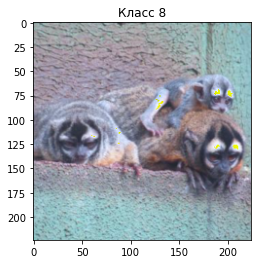

In [74]:
#пример картинки
img = torchvision.utils.make_grid(images[0])
img = img * 0.2 + 0.5     
npimg = img.numpy()
plt.imshow((np.transpose(npimg, (1, 2, 0))* 255).astype(np.uint8))
plt.title('Класс '+ str(labels[0].item()))
plt.show()

In [75]:
print('Количество классов', len(torch.unique(labels)))

Количество классов 10


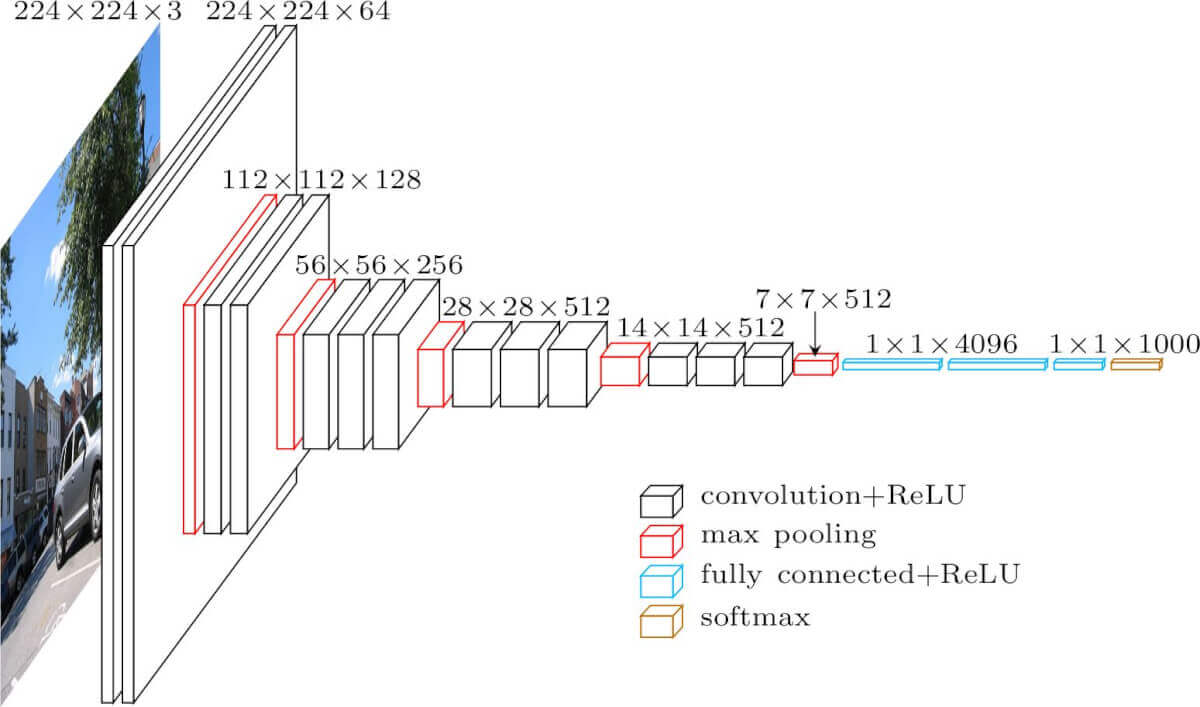

In [103]:
from torchvision import models
model = models.vgg16(weights = 'DEFAULT')

С замораживанием весов:

In [104]:
# Эта модель имеет более 130 миллионов параметров, но мы будем обучать только самые последние несколько 
# полностью связанных слоев. Первоначально мы замораживаем все веса модели:
for param in model.parameters():
    param.requires_grad = False

In [105]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [106]:
# Затем мы добавляем наш собственный классификатор 
model.classifier[6] = nn.Sequential(
                      nn.Linear(4096, 256), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(256, 10))

In [107]:
from sklearn.metrics import accuracy_score

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses = []
test_losses = []

for i in range(3):
    model.train()
    losses_epoch_train = []
    losses_epoch_test = []
    y_pred_test = []
    y_true_test = []
    for x_example, y_example in train_loader:
        y_pred = model(x_example)
    
        loss = criterion(y_pred, y_example)
        losses_epoch_train.append(loss.item())
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()
        
    for x_example, y_example in test_loader:
        y_pred = model(x_example)
    
        loss = criterion(y_pred, y_example)
        losses_epoch_test.append(loss.item())
        
        y_pred_test.extend(y_pred)
        y_true_test.extend(y_example)
        
    train_losses.append(np.mean(losses_epoch_train))
    test_losses.append(np.mean(losses_epoch_test))
    y_pred_test = list(map(lambda x: torch.argmax(x).item(), y_pred_test))
    y_true_test = list(map(lambda x: x.item(), y_true_test))
    print(f'epoch {i}: train_loss = {np.mean(losses_epoch_train):.8f}, test_loss = {np.mean(losses_epoch_test):.8f}') 
    print('Точность на тестовой выборке:', accuracy_score(y_true_test, y_pred_test))

epoch 0: train_loss = 0.71798477, test_loss = 0.11485655
Точность на тестовой выборке: 0.9595588235294118
epoch 1: train_loss = 0.05123192, test_loss = 0.08238010
Точность на тестовой выборке: 0.9779411764705882
epoch 2: train_loss = 0.05174107, test_loss = 0.07584423
Точность на тестовой выборке: 0.9669117647058824


In [108]:
y_pred = []
y_true = []
for x,y in test_loader:
    y_pred.extend(model(x))
    y_true.extend(y)
y_pred = list(map(lambda x: torch.argmax(x).item(), y_pred))
y_true = list(map(lambda x: x.item(), y_true))

In [109]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_true, y_pred)

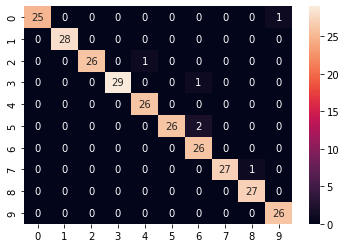

In [110]:
import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True)
plt.show()

In [111]:
from sklearn.metrics import accuracy_score
print('Точность на тестовой выборке:', accuracy_score(y_true, y_pred))

Точность на тестовой выборке: 0.9779411764705882


### 4.2 Решить задачу 3.2, воспользовавшись подходящей предобученной моделью
* Не использовать VGG16 (вместо нее можно взять resnet18 или другую)
* Загрузить данные для обучения
* Преобразования: размер 224x224, нормализация с параметрами `mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)`
* Заменить последний полносвязный слой модели в соответствии с задачей
* Дообучить модель. 
* Вычислить значение accuracy на тестовом множестве (добиться значения не меньше 97-98%)

In [2]:
import zipfile
from tqdm import tqdm

zf = zipfile.ZipFile('cats_dogs.zip')
for file in tqdm(zf.infolist()):
    zf.extract(file)

100%|███████████████████████████████████████████████████████████████████████████| 25004/25004 [00:37<00:00, 660.64it/s]


In [5]:
transform = transforms.Compose([transforms.Resize(224),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
dataset = torchvision.datasets.ImageFolder(root='cats_dogs/train', transform = transform)
data_train, data_test = torch.utils.data.random_split(dataset, [int(25000*0.8), 25000 - int(25000*0.8)])

In [6]:
train_loader = DataLoader(data_train, batch_size = 1, shuffle = True)
test_loader = DataLoader(data_test, batch_size = 1, shuffle = True)

In [12]:
images, labels = next(iter(train_loader))

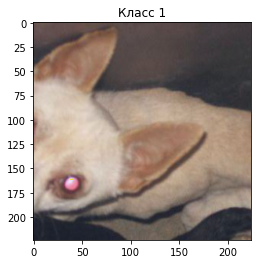

In [13]:
#пример картинки
img = torchvision.utils.make_grid(images[0])
img = img * 0.2 + 0.5     
npimg = img.numpy()
plt.imshow((np.transpose(npimg, (1, 2, 0))* 255.astype(np.uint8))
plt.title('Класс '+ str(labels[0].item()))
plt.show()

In [18]:
from torchvision import models
model = models.vgg11(weights = 'DEFAULT')
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [19]:
for param in model.parameters():
    param.requires_grad = False

In [20]:
model.classifier[6] = nn.Sequential(
                      nn.Linear(4096, 256), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(256, 2))

In [22]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [21]:
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

129,815,682 total parameters.
1,049,346 training parameters.


In [23]:
from sklearn.metrics import accuracy_score

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses = []
test_losses = []

for i in range(5):
    model.train()
    losses_epoch_train = []
    losses_epoch_test = []
    y_pred_test = []
    y_true_test = []
    for x_example, y_example in train_loader:
        y_pred = model(x_example)
    
        loss = criterion(y_pred, y_example)
        losses_epoch_train.append(loss.item())
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()
        
    for x_example, y_example in test_loader:
        y_pred = model(x_example)
    
        loss = criterion(y_pred, y_example)
        losses_epoch_test.append(loss.item())
        
        y_pred_test.extend(y_pred)
        y_true_test.extend(y_example)
        
    train_losses.append(np.mean(losses_epoch_train))
    test_losses.append(np.mean(losses_epoch_test))
    y_pred_test = list(map(lambda x: torch.argmax(x).item(), y_pred_test))
    y_true_test = list(map(lambda x: x.item(), y_true_test))
    print(f'epoch {i}: train_loss = {np.mean(losses_epoch_train):.8f}, test_loss = {np.mean(losses_epoch_test):.8f}') 
    print('Точность на тестовой выборке:', accuracy_score(y_true_test, y_pred_test))
    if accuracy_score(y_true_test, y_pred_test)>0.97:
        break

epoch 0: train_loss = 0.15141985, test_loss = 0.10415630
Точность на тестовой выборке: 0.978


In [24]:
y_pred = []
y_true = []
for x,y in test_loader:
    y_pred.extend(model(x))
    y_true.extend(y)
y_pred = list(map(lambda x: torch.argmax(x).item(), y_pred))
y_true = list(map(lambda x: x.item(), y_true))

In [25]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_true, y_pred)

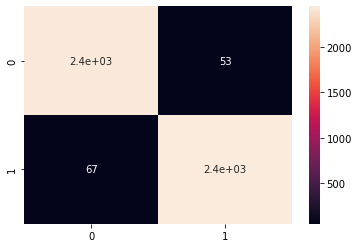

In [26]:
import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True)
plt.show()

In [27]:
from sklearn.metrics import accuracy_score
print('Точность на тестовой выборке:', accuracy_score(y_true, y_pred))

Точность на тестовой выборке: 0.976
